# Trash detection with Unet on the TACO Dataset

In this notebook, we evaluate the performance of [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) on the [Trash Annotations in Context (TACO) dataset](http://tacodataset.org/). TACO consists of 1500 photos of litter taken in diverse environments, annotated according to the [COCO](http://cocodataset.org/#home) format.


# Setting up

First, we install all dependencies required:

In [ ]:
!pip install torch torchvision
!pip install -q kaggle

import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
import random
import os
import time
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np

from PIL import Image, ExifTags
from pathlib import Path
from typing import Tuple

from google.colab import drive
from google.colab import files

import json
import urllib.request
from pycocotools.coco import COCO
import skimage.io as io

import copy


np.random.seed(1)
random.seed(1)

torch.cuda.set_device(0)
torch.manual_seed(0)

Let's also mount a drive to efficiently store results:


In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Download a resized version of the TACO Dataset:
To download a dataset from Kaggle, you need a `kaggle.json` file that contains your Kaggle credentials. The `kaggle.json` file can be downloaded from the website under Account > Create new API token. Then `KAGGLE_CONFIG_DIR` should point to the directory that contains the `kaggle.json`. 

In [ ]:
def download_data(dataset_name = "taco-dataset-resized-640", dataset_destination = "taco-dataset-resized-640"):
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
  if not Path(f"/content/{dataset_destination}").exists():
    print(f"Downloading and unpacking {dataset_name}...")
    !kaggle datasets download "verahoveling/"$dataset_name
    !unzip -q "/content/"$dataset_name".zip" -d $dataset_destination

def download_masks(dataset_name = "taco-dataset-resized-640-masks", dataset_destination = "taco-dataset-resized-640-masks"):
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
  if not Path(f"/content/{dataset_destination}").exists():
    print(f"Downloading and unpacking {dataset_name}...")
    !kaggle datasets download "sranjha/"$dataset_name
    !unzip -q "/content/"$dataset_name".zip" -d $dataset_destination

download_data()
download_masks()

 96% 121M/126M [00:02<00:00, 52.8MB/s]
100% 126M/126M [00:02<00:00, 53.2MB/s]
  0% 0.00/1.80M [00:00<?, ?B/s]
100% 1.80M/1.80M [00:00<00:00, 61.1MB/s]


A class for the TACO Dataset

In [ ]:
class TacoDataset(torch.utils.data.Dataset):
    def __init__(self, img_root, mask_root, annotation_file, transforms=None, usePadding=True, randomCrop=False, randomRotation=False):
        self.img_root = img_root
        self.mask_root = mask_root
        self._image_ids = []
        self.transforms = transforms
        self.imgs = {}
        self.masks = {}
        self.usePadding = usePadding
        self.randomCrop = randomCrop
        self.randomRotation = randomRotation

        annotations = json.load(Path(annotation_file).open("r"))
        images = annotations['images']
        for image in images:
            image_path = Path(img_root).joinpath(image['file_name'])
            image_id = image['id']
            mask_path = Path(mask_root).joinpath(f"{image_id}.pt")
            self._image_ids.append(image_id)

            self.imgs[image_id] = image_path
            self.masks[image_id] = mask_path

    @property
    def image_ids(self):
        return self._image_ids


    def load_image(self, idx):
        """Load the specified image and return as a [H,W,3] Numpy array."""
        image = Image.open(Path(self.img_root).joinpath(self.imgs[idx]))
        img_shape = np.shape(image)

        # load metadata
        exif = image._getexif()
        if exif:
            exif = dict(exif.items())
            # Rotate portrait images if necessary (274 is the orientation tag code)
            if 274 in exif:
                if exif[274] == 3:
                    image = image.rotate(180, expand=True)
                if exif[274] == 6:
                    image = image.rotate(270, expand=True)
                if exif[274] == 8:
                    image = image.rotate(90, expand=True)

        # If has an alpha channel, remove it for consistency
        if img_shape[-1] == 4:
            image = image[..., :3]

        return np.array(image)

    @staticmethod
    def pad(image, target):
        # padding_left, padding_right, padding_top, padding_bottom
        pad_left = 640 - image.shape[2]
        pad_bottom = 640 - image.shape[1]
        image = torch.nn.functional.pad(image, pad=(0, pad_left, 0, pad_bottom), mode='constant', value=255)
        target = torch.nn.functional.pad(target, pad=(0, pad_left, 0, pad_bottom), mode='constant', value=0)
        
        return (image, target)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image = self.load_image(idx)
        image = np.moveaxis(image, [0, 1, 2], [1, 2, 0])
        image_tensor = torch.tensor(image)
        image_tensor = image_tensor.float()
        image_tensor = image_tensor / 255
        if self.transforms is not None:
            image_tensor = self.transforms(image_tensor)

        mask = torch.load(Path(self.mask_root).joinpath(self.masks[idx]))
        mask = mask.long()
        if self.randomRotation:
          numrots = random.randint(1,4)
          np.rot90(image_tensor, k=numrots, axes=(1, 2))
          np.rot90(mask, k=numrots, axes=(0, 1))

        if self.randomCrop:
          image_tensor, mask = self.pad(image_tensor, mask)
          i, j, h, w = transforms.RandomCrop.get_params(image_tensor, output_size=(400, 400))
          cropped_image = image_tensor[:, i:i + h, j:j + w]
          cropped_mask = mask[i:i + h, j:j + w]
          image_tensor = F.pad(input=image_tensor, pad=(80, 80, 80, 80, 0, 0), mode='constant', value=0)
          return (cropped_image, cropped_mask)
        elif self.usePadding:
          image_tensor = F.pad(input=image_tensor, pad=(80, 80, 80, 80, 0, 0), mode='constant', value=0)
          return self.pad(image_tensor, mask)
        else: 
          image_tensor = F.pad(input=image_tensor, pad=(80, 80, 80, 80, 0, 0), mode='constant', value=0)
          return (image_tensor, mask)                 

And additional helper functions for that class:

In [ ]:
def get_taco_dataset(usePadding=True, randomCrop=False, randomRotation=False):
  preprocess = transforms.Compose([
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  return TacoDataset('/content/taco-dataset-resized-640/content', '/content/taco-dataset-resized-640-masks/masks_pt', '/content/taco-dataset-resized-640/content/annotations.json', transforms=preprocess, usePadding=usePadding, randomCrop=randomCrop, randomRotation=randomRotation)

def get_samplers(dataset, val_split=0.1, test_split=0.1, shuffle_dataset=True):
  dataset_size = len(dataset.image_ids)
  indices = list(range(dataset_size))
  val_split = int(np.floor(val_split * dataset_size))
  test_split = int(np.floor(test_split * dataset_size))

  np.random.seed(1)
  if shuffle_dataset :
      np.random.shuffle(indices)
  train_indices = indices[(test_split+val_split):]
  val_indices = indices[test_split:(test_split+val_split)]
  test_indices = indices[:test_split]
  print(test_indices)

  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)


  return train_sampler, val_sampler, test_sampler

def get_dataloaders(dataset, batch_size, shuffle_dataset=True, collate_fn=None, test_batch_size=1):
  train_sampler, val_sampler, test_sampler = get_samplers(dataset=dataset, shuffle_dataset=shuffle_dataset)
  
  train_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=batch_size, 
                                     drop_last=True, 
                                     sampler=train_sampler,
                                     collate_fn=collate_fn)
  
  val_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=test_batch_size, 
                                     drop_last=True, 
                                     sampler=val_sampler,
                                     collate_fn=collate_fn)
  
  test_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=test_batch_size, 
                                     drop_last=True, 
                                     sampler=test_sampler,
                                     collate_fn=collate_fn)
  
  return train_loader, val_loader, test_loader

# Network Architecture

We re-use the architecture that was made for the reproduction project of the course CS4240. The original report and code can be found on [reproducedpapers.org](https://reproducedpapers.org/papers/HCCpp9BNEnUl0z6moLmg#rztA9goB4I5S1YB8Ah4up). The code below as a few very small adaptations to handle the TACO Dataset but is otherwise completely the same.

## Utility methods


In [ ]:
def center_crop_feature_map(feature_map: torch.Tensor, target_tensor: torch.Tensor) -> torch.Tensor:
  """Center crop a feature map in the x, y dimension to match the size of the 
  target tensor.
  
  Params
  ------
  feature_map: torch.Tensor
    an 1 x 1 x H x W tensor representing a feature map

  target_tensor: torch.Tensor
    an 1 x 1 x H_crop x W_crop tensor whose size should be matched

  Returns
  -------
  torch.Tensor
    the feature_map center cropped to 1 x 1 x H_crop x W_crop

  """
 
  _, _, feature_map_height, feature_map_width = feature_map.size()
  _, _, target_height, target_width = target_tensor.size()
  diff_y = (feature_map_height - target_height) // 2
  diff_x = (feature_map_width - target_width) // 2

  
  return feature_map[
          :, :, diff_y: (diff_y + target_height), diff_x: (diff_x + target_width)
          ]

def center_crop_image_tensor(in_tensor: torch.Tensor, target_dim: Tuple[int, int]) -> torch.Tensor:
  """Center crop an image tensor in the x, y dimension to match the target
  dimensions.

  Params
  ------
  in_tensor: torch.Tensor
    a 1 x H x W tensor representing an image

  target_dim: Tuple[int, int]
    contains the target dimensions, H_crop and W_crop

  Returns
  -------
  torch.Tensor
    the in_tensor center cropped to 1 x H_crop x W_crop

  """

  _, input_height, input_width = in_tensor.size()

  diff_y = (input_height - target_dim[0]) // 2
  diff_x = (input_width - target_dim[1]) // 2


  return in_tensor[:, diff_y : diff_y + target_dim[0], diff_x : diff_x + target_dim[1]]

def get_loss(data_loader: DataLoader, net: nn.Module, criterion) -> float:
  """Get average loss on the data in the given dataloader.
  
  Params
  ------
  data_loader: DataLoader
    has the data over which the loss should be computed

  net: nn.Module
    neural net that produces an output

  criterion: 
    loss function

  """
  running_loss = 0
  for (image, label) in data_loader:
    image = image.cuda(0)
    label = label.cuda(0)
    out = net(image)

    _,_,oh,ow = out.size()
      
    label = center_crop_image_tensor(label, (oh, ow))
      

    loss = criterion(out, label)
    running_loss += loss.item()
  return running_loss / len(data_loader)

def plot_learning_curve(train_losses: list, test_losses: list, title: str, save_plot = False):
  iterations = range(0, len(train_losses))
  plt.figure(figsize=(20,15))
  plt.plot(iterations, train_losses, label= "train")
  plt.plot(iterations, test_losses, label= "test")
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  if save_plot:
    plt.savefig(f"/content/drive/My Drive/{title}.png")
  plt.show()

## Network

In [ ]:
def conv(kernel_size: int, in_channels: int, out_channels: int) -> nn.Conv2d:
  """Create a 2d convolutional layer.
  
  Params
  ------
  kernel_size: int
    the kernel will have size (kernel_size x kernel_size)

  in_channels: int
    the number input feature maps

  out_channels: int
    the number of output feature maps

  Returns
  -------
  Conv2d
    a kernel_size x kernel_size convolutional layer
  """

  return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=0)

def conv_activate(in_channels: int, out_channels: int, init_method) -> nn.Sequential:
  """Two 3x3 convolutions followed by relus.
  
  Params
  ------
  in_channels: int
    number of input feature maps for the first convolution

  out_channels: int
    number of input maps for the second convolution; number of output feature 
    maps for both convolutions

  Returns
  -------
  nn.Sequential
    sequence of a 3x3 convolution, relu, 3x3 convolution, relu
  """
  c1 = conv(3, in_channels, out_channels)
  c2 = conv(3, out_channels, out_channels)

  if init_method == 'xavier':
    torch.nn.init.xavier_normal_(c1.weight) 
    torch.nn.init.xavier_normal_(c2.weight) 
  elif init_method == 'kaiming':
    torch.nn.init.kaiming_normal_(c1.weight)
    torch.nn.init.kaiming_normal_(c2.weight)
  else:
    raise ValueError(f"Invalid weight initialization method {init_method}.")
    
  return nn.Sequential(
      c1,
      nn.ReLU(),
      c2,
      nn.ReLU())

class Contraction(nn.Module):
  """Class representing one step in the contracting path.
  
  One step consists of two 3x3 convolutions, each followed by a relu. These
  convolutions/relus are then followd by a max pooling operation. Both the 
  result from the convs/relus and the max pooling are returned, as the former
  is needed for the expanding path, and the latter for continuing the 
  contracting path.
  """

  def __init__(self, in_channels: int, out_channels: int, init_method: str):
    super(Contraction, self).__init__()
    
    self.conv_activate = conv_activate(in_channels, out_channels, init_method)
    self.maxpool = nn.MaxPool2d(2)
   
  def forward(self, x):
    x = self.conv_activate(x) 
    mp = self.maxpool(x)

    return mp, x
    
class Expansion(nn.Module):
  """Class representing one step in the expanding path.

  One step consists of either:
    1. An upsampling followed by a 2x2 convolution.
    2. A 2x2 transpose convolution.

    Both of these act on the output from the previous layer concatenated
    with the feature map from the corresponding layer in the contracting path.

  Followed by two 3x3 convolutions, each followed by a relu.
  """

  def __init__(self, in_channels: int, out_channels: int, up_method: str, init_method: str):
    super(Expansion, self).__init__()
    
    if up_method == 'upsample':
      self.up2x2 = nn.Sequential(
          nn.Upsample(scale_factor=2, mode = 'nearest'), # mode is nearest to match keras' default
          conv(2, in_channels, out_channels)
      )
    elif up_method == 'transpose':
      self.up2x2 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    else:
      print("Invalid upconvolution method.")

    self.conv_activate = conv_activate(in_channels, out_channels, init_method)

  def forward(self, x, fm):
    """
    Params
    ------
    fm
      feature map from the corresponding layer in the contracting path
    """
    
    x = self.up2x2(x)

    # concatenate the previously extracted feature map with the upsampled map
    fm = center_crop_feature_map(fm, x)
    x = torch.cat([fm, x], dim=1)  
    x = self.conv_activate(x)
      
    return x


class UNet(nn.Module):
  def __init__(self, num_classes: int, up_method = 'upsample', init_method = 'kaiming'):
    super(UNet, self).__init__()    

    self.contraction1 = Contraction(3, 64, init_method)
    self.contraction2 = Contraction(64, 128, init_method)
    self.contraction3 = Contraction(128, 256, init_method)
    self.contraction4 = Contraction(256, 512, init_method)

    self.bottomlayer = Contraction(512, 1024, init_method)
    
    self.expansion4 = Expansion(1024, 512, up_method, init_method)
    self.expansion3 = Expansion(512, 256, up_method, init_method)
    self.expansion2 = Expansion(256, 128, up_method, init_method)
    self.expansion1 = Expansion(128, 64, up_method, init_method)
    self.map_to_classes = conv(1, 64, num_classes)
    if init_method == 'xavier':
      torch.nn.init.xavier_normal_(self.map_to_classes.weight)
    elif init_method == 'kaiming':
      torch.nn.init.kaiming_normal_(self.map_to_classes.weight)
    else:
      raise ValueError(f"Invalid weight initialization method {init_method}.")
    

  def forward(self, x):
    
    x = x.float()
    feature_maps = []

    x, fm = self.contraction1(x)
    feature_maps.append(fm)
    x, fm = self.contraction2(x)
    feature_maps.append(fm)    
    x, fm = self.contraction3(x)
    feature_maps.append(fm)
    x, fm = self.contraction4(x)
    feature_maps.append(fm)

    _, x = self.bottomlayer(x)
    x = self.expansion4(x, feature_maps[3]) 
    x = self.expansion3(x, feature_maps[2])
    x = self.expansion2(x, feature_maps[1])
    x = self.expansion1(x, feature_maps[0])
    x = self.map_to_classes(x)
    return x

## Training method


In [ ]:
def plot_learning_curve(train_losses: list, test_losses: list, title: str, save_plot = False, save_dir = None):
  """Plots and shows training vs. test losses.
  The number of train losses should be equal to the number of test losses.

  Params
  ------
  train_losses: list
    training losses as floating point values
  
  train_losses: list
    test losses as floating point values

  title: str
    title of the plot

  save_plot: bool
    whether or not the plot should be saved

  """
  iterations = range(0, len(train_losses))
  plt.figure(figsize=(20,15))
  plt.plot(iterations, train_losses, label= "train")
  plt.plot(iterations, test_losses, label= "test")
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  if save_plot:
    if save_dir is not None:
      plt.savefig(f"{save_dir}{title}.png")
    else:
      print("No save directory provided. Curve was not saved.")
  plt.show()

In [ ]:
def train_unet(train_loader: DataLoader, test_loader: DataLoader, 
               up_method = 'upsample', init_method='kaiming', num_classes = 29, 
               num_epochs = 10, logging_mode = 'fine',
               logging_interval = 25, early_stop_patience = 5, early_stop_treshold = 1e-3,
               plot_curve: bool = True, save_model: bool = True, save_dir: str = None) -> (UNet, list, list):
  
  if save_model and save_dir is None:
    print("Model is supposed to be saved, but no save directory was provided.")
    print("No training will take place.")
    return
  
  print("Started.")
  net: UNet = UNet(num_classes=num_classes, up_method=up_method, init_method=init_method)
  net.train()
  net.cuda(0)

  criterion = nn.CrossEntropyLoss(ignore_index=255)
  optimizer = optim.SGD(net.parameters(), lr= 0.0001, momentum=0.99)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr = 1e-5)
  
  train_losses = []
  test_losses = []
  min_loss = float("inf")
  early_stop_timer = 0
  stopping_epoch = 0
  for epoch in range(num_epochs):
    stopping_epoch = epoch + 1
    running_loss = 0.0
    e_start = time.time()
    for i, (image, label) in enumerate(train_loader):      
      image = image.cuda(0)
      label = label.cuda(0)

      output = net(image)
      _, _, oh, ow = output.size()
      
      label = center_crop_image_tensor(label, (oh, ow))
      loss = criterion(output, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()    

      running_loss += loss.item()
      
      if i % logging_interval == logging_interval - 1:
        if logging_mode == "fine":
          print(f'[{epoch + 1}, {i + 1}] loss: {running_loss/logging_interval}')
        if plot_curve:  
          train_losses.append(running_loss/logging_interval)
        running_loss = 0.0
        
        if plot_curve:
          net.eval()
          test_loss = get_loss(test_loader, net, criterion)
          test_losses.append(test_loss)
          net.train()

    if logging_mode == 'fine' or logging_mode == 'coarse':  
      print(f'[{epoch + 1}/{num_epochs}] completed in {time.time() - e_start} seconds')  

    net.eval()
    epoch_test_loss = get_loss(test_loader, net, criterion)
    net.train()
    scheduler.step(epoch_test_loss)

    if min_loss - epoch_test_loss > early_stop_treshold:
      if logging_mode == "fine":
        print(f"Loss diff {min_loss - epoch_test_loss} larger than treshold {early_stop_treshold}.")
      min_loss = epoch_test_loss
      early_stop_timer = 0
    else:
      early_stop_timer += 1
      if logging_mode == "fine":
        print(f"Loss diff {min_loss - epoch_test_loss} smaller than treshold {early_stop_treshold}.")
        print(f"Early stop timer increased to {early_stop_timer}.")
    if early_stop_timer >= early_stop_patience:
      break
    if save_model:
      checkpoint = { 
        'epoch': epoch,
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict()}
        # 'lr_sched': scheduler.state_dict()}
      torch.save(checkpoint, f'{save_dir}/checkpoint_{up_method}_{init_method}_{num_epochs}_{len(train_loader)}.pth')

  if logging_mode == 'fine' or logging_mode == 'coarse':
    print(f"Stopped training after {stopping_epoch} epochs.")

  if save_model:
    torch.save(net.state_dict(), f'{save_dir}/model_{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}.pth')
    print(f"Saved model to {save_dir}/model_{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}.pth")

  if plot_curve:
    plot_learning_curve(train_losses, test_losses, f"{up_method}_{init_method}_{num_epochs}_{stopping_epoch}_{len(train_loader)}", save_plot=True, save_dir = save_dir)
  
  return net, train_losses, test_losses



# Let's train the network!
## First, we made the dataset and get the dataloaders:

In [ ]:
dataset = get_taco_dataset(usePadding=True, randomCrop=False, randomRotation=True)
train_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size=5)

using 1500/1500
dataset size = 1500
[91, 75, 1264, 330, 1349, 774, 1038, 1285, 1165, 335, 685, 181, 1220, 101, 692, 1126, 169, 926, 1295, 414, 1410, 1279, 1464, 808, 102, 1399, 1243, 922, 1297, 761, 1158, 292, 1336, 1199, 231, 1037, 1141, 37, 53, 1009, 925, 561, 679, 589, 894, 697, 1211, 895, 1460, 194, 1176, 1259, 1104, 484, 990, 1179, 460, 1351, 421, 596, 1032, 1431, 572, 496, 1244, 304, 268, 309, 1371, 535, 1048, 453, 923, 547, 985, 1382, 1055, 140, 435, 1053, 301, 1047, 521, 1043, 527, 1068, 1173, 167, 462, 390, 823, 629, 48, 872, 111, 793, 631, 857, 386, 1078, 1396, 1426, 1134, 771, 80, 512, 636, 107, 577, 1407, 1477, 827, 950, 597, 60, 498, 119, 375, 1156, 620, 639, 1284, 881, 1087, 368, 1378, 644, 870, 19, 1093, 331, 201, 283, 898, 3, 1092, 443, 396, 553, 1231, 1245, 1237, 1251, 49, 587, 703, 1472, 104, 1166, 255]


### Train the network


Started.
[1, 25] loss: 3.421675796508789
[1, 50] loss: 2.807900514602661
[1, 75] loss: 1.27072507917881
[1, 100] loss: 0.8977126511931419
[1, 125] loss: 1.5390224811434745
[1, 150] loss: 1.0927685958147049
[1, 175] loss: 0.472095759510994
[1, 200] loss: 0.714551386833191
[1, 225] loss: 0.6353604996204376
[1/10] completed in 1471.6359884738922 seconds
Loss diff inf larger than treshold 0.001.
[2, 25] loss: 0.4462579907476902
[2, 50] loss: 0.5019890777766705
[2, 75] loss: 0.499025916159153
[2, 100] loss: 0.34014729380607606
[2, 125] loss: 0.35491975367069245
[2, 150] loss: 0.4086341869831085
[2, 175] loss: 0.3942978087067604
[2, 200] loss: 0.3112134191393852
[2, 225] loss: 0.31481028959155083
[2/10] completed in 1461.9304175376892 seconds
Loss diff 0.0647476287931204 larger than treshold 0.001.
[3, 25] loss: 0.3542401146888733
[3, 50] loss: 0.30847021579742434
[3, 75] loss: 0.42752478897571566
[3, 100] loss: 0.3680280575156212
[3, 125] loss: 0.35086644858121874
[3, 150] loss: 0.317150436

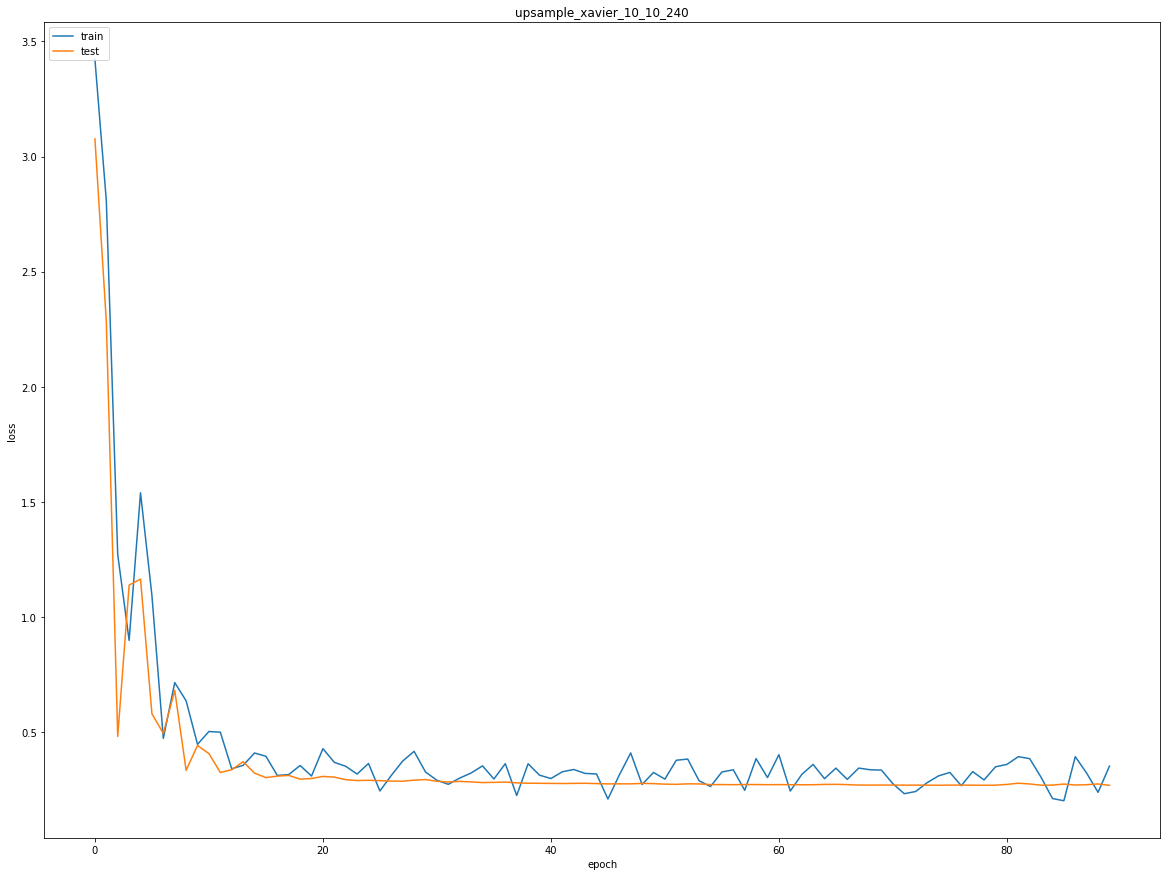

In [ ]:
save_dir = "/content/drive/My Drive/CV-models"
net, trloss, tloss = train_unet(train_loader, val_loader, up_method = 'upsample', init_method='xavier',num_epochs = 10, num_classes = 29, save_dir = save_dir, early_stop_patience=15)


## Evaluate the network

## Evaluation Methods



In [ ]:
def true_false_pos_neg(output: np.ndarray, label: np.ndarray, threshold: float):
  output[output > threshold] = 1
  output[output <= threshold] = 0

  true_pos = np.sum((output == label) & (output == 1))
  false_pos = np.sum((output != label) & (output == 1))
  true_neg = np.sum((output == label) & (output == 0))
  false_neg = np.sum((output != label) & (output == 0))

  return true_pos, false_pos, true_neg, false_neg

def f_score(output: np.ndarray, label: np.ndarray, threshold: float):
  true_pos, false_pos, true_neg, false_neg = true_false_pos_neg(output, label, threshold)

  precision, recall, fscore = 0, 0, 0

  if false_pos == 0 : 
    precision = 1
  else:  
    precision = true_pos / (true_pos + false_pos)

  if false_neg == 0:
    recall = 1
  else:
    recall = true_pos / (true_pos + false_neg)

  if precision + recall > 0:
    fscore = 2 * precision * recall / (precision + recall)  
  return fscore

def best_f_score(output, label):
  thresholds = np.linspace(0,1,11)
  best_f = 0

  for thr in thresholds:
    new_f = f_score(output, label, thr)
    if new_f > best_f:
      best_f = new_f
  return best_f

def pixel_error(output, label):
  best_f = best_f_score(output.copy(), label)
  return 1 - best_f


def naive_pixel_error(output: np.ndarray, label: np.ndarray):
  """Calculates the percentage of pixels that were NOT correctly classified.

  Params
  ------
  output: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled with a 1
    representing the predicted labels

  label: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled with a 1
    representing the true labels
  
  """

  return np.sum(output != label)/output.size

def intersection_over_union(predicted: np.ndarray, label: np.ndarray):
  """Calculates the intersection over union of the output and the true label.

  Params
  ------
  predicted: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled 
    with a 1; represents the predicted labels

  label: np.ndarray
    a 2-dimensional integer array in which the background pixels are labeled 
    with a 1; represents the true labels
  
  """
  
  intersection = (predicted & label).sum((0,1))
  union = (predicted | label).sum((0,1))
  return intersection / union


def binary_mask(image: np.ndarray, chan = 1):
  """Apply mask to image. Every value over 0.5 becomes a 1, every value
  under 0.5 becomes a 0.
  
  Params
  ------
  image: np.ndarray
    a H X W X C image; H is height, W is width, C is channels (assumed to be 2)

  chan: int
    whether the correct labelings can be found in channel 0 or 1
  """

  masked = image[:,:,chan]
  masked[masked < 0.5] = 0
  masked[masked >= 0.5] = 1
  return masked.astype('int')

def argmax_mask(image: np.ndarray):
  """Apply mask to an image. Finds the index of the channel with the largest
  value.

  Params
  ------
  image: np.ndarray
    H X W X C image
    H is the height, W the width, C the number of channels
  """
  return np.argmax(image, axis=2)



## Load network

If you trained a network earlier in this notebook you don't need to load one, but if you want to, this is where you can do it!

In [ ]:
net = UNet(num_classes=29, up_method='upsample', init_method='xavier')
net.load_state_dict(torch.load("/content/drive/My Drive/CV-models/model_upsample_xavier_10_10_240.pth"))
net.cuda(0)
print()

### Get output



In [ ]:
with torch.no_grad():
  cropped_images = []
  seg_images = []
  masked_images = []
  argmasked_images = []
  cropped_labels = []
  labels = []
  outputs = []

  for i, (image, label) in enumerate(test_loader): 

    image = image.cuda(0)
    out = net(image)
    out = out.cpu()

    labels.append(label)
    outputs.append(out.argmax(1))

    img_size = image.size()
    ob, oc, oh, ow = out.size()

    out = out.reshape(oc, oh, ow).permute(1,2,0).detach().numpy()

    seg_images.append(out)
    masked_images.append(binary_mask(out))
    argmasked_images.append(np.argmax(seg_images[i], axis=2))
    cropped_labels.append(center_crop_image_tensor(label, (oh, ow)).reshape(oh, ow).detach().numpy())
    # print(center_crop_image_tensor(label, (oh, ow)).reshape(oh, ow).detach().numpy().shape)
    # crop_img = center_crop_image_tensor(image.cpu().reshape(3,img_size[2],(img_size[3])), (3, oh, ow))
    # print(crop_img.size())
    # cropped_images.append(center_crop_image_tensor(image.cpu().reshape(3,img_size[2],(img_size[3])), (3, oh, ow)).reshape(3, oh, ow).detach().numpy())

# Inspect output of the model

torch.Size([1, 480, 480])
torch.Size([1, 437, 437])


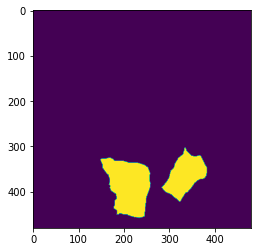

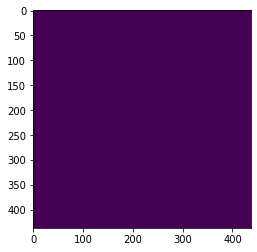

tensor(0)


In [ ]:
idx = 0
print(labels[idx].shape)
print(outputs[idx].shape)
plt.imshow(labels[idx].reshape(labels[idx].shape[1],labels[idx].shape[2]))
plt.show()
plt.imshow(outputs[idx].reshape(outputs[idx].shape[1],outputs[idx].shape[2]))
plt.show()
print(sum(sum(sum(sum(outputs)))))

### Evaluate


In [ ]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask] + label_pred[mask],
        minlength=n_class ** 2,
    ).reshape(n_class, n_class)
    return hist

def scores(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        lt = lt.to('cpu')
        lp = lp.to('cpu')
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    valid = hist.sum(axis=1) > 0  # added
    mean_iu = np.nanmean(iu[valid])
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    cls_iu = dict(zip(range(n_class), iu))

    return {
        "Pixel Accuracy": acc,
        "Mean Accuracy": acc_cls,
        "Frequency Weighted IoU": fwavacc,
        "Mean IoU": mean_iu,
        "Class IoU": cls_iu,
    }

def evaluate_metrics(model, test_loader, num_classes):
  #model.eval()
  labels = []
  outputs = []

  for i, (image, label) in enumerate(test_loader):      
    image = image.cuda(0)
    output = model(image)
    # output = output.cpu()
    output = torch.nn.functional.softmax(output)
    output = output.cpu() 

    # output = output['out']
    
    labels.append(label)
    outputs.append(output.argmax(1))

    
  return scores(labels, outputs, num_classes)

In [ ]:
eval_results = scores(labels, outputs, 29)
print(eval_results)

#Further evaluate output

In [ ]:
IOUs = []
naive_pixel_errors = []
pixel_errors = []

for i in range(0, len(cropped_labels)):
  IOUs.append(intersection_over_union(masked_images[i], cropped_labels[i]))
  naive_pixel_errors.append(naive_pixel_error(masked_images[i], cropped_labels[i]))
  pixel_errors.append(pixel_error(seg_images[i][:,:,1], cropped_labels[i]))

print(sum(IOUs)/len(IOUs))
print(sum(naive_pixel_errors)/len(naive_pixel_errors))
print(sum(pixel_errors)/len(pixel_errors))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in long_scalars


nan
0.04529201933059931
0.85


### Plot images


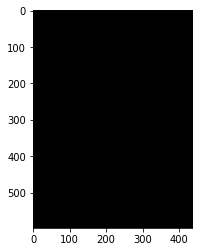

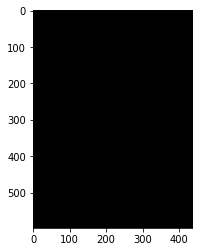

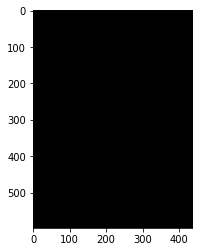

In [ ]:
plt.imshow(seg_images[0][:,:,1], cmap='gray')
plt.show()

plt.imshow(argmasked_images[0], cmap='gray')
plt.show()

plt.imshow(masked_images[0], cmap= 'gray')
plt.show()